In [1]:
# Used modules
import re
import time
import warnings
import pandas as pd
import numpy as np
import tldextract as tlx
import matplotlib.pyplot as plt
import seaborn as sns
from urlparse import urlparse

plt.style.use('classic')
%matplotlib inline

sns.set()

# Loading the dataset

In [2]:
initial_dataset =  pd.read_csv('../data/data_21K_good_and_malicious_URLs.csv')
initial_dataset.head()

,url,label
0,startbuyingstocks.com/,0
1,qqcvk.com/,0
2,432parkavenue.com/,0
3,gamefoliant.ru/,0
4,orka.cn/,0


In [3]:
def print_df_shape(df):
    rows = df.shape[0]
    cols = df.shape[1]
    print str(rows) + '\trows'
    print str(cols) + '\tcolumns'

In [4]:
def remove_duplicates(dataset):
    dataset.dropna(inplace=True)
    dataset.drop_duplicates(inplace=True)
    dataset.reset_index(drop=True)

In [5]:
print 'Before removing duplicates:'
print_df_shape(initial_dataset)
old_number_of_rows = initial_dataset.shape[0]

remove_duplicates(initial_dataset)

print '\nAfter removing duplicates:'
print_df_shape(initial_dataset)
new_number_of_rows=initial_dataset.shape[0]

print "\n" + str(old_number_of_rows - new_number_of_rows) + ' rows were removed'

Before removing duplicates:
20905	rows
2	columns

After removing duplicates:
20875	rows
2	columns

30 rows were removed


In [6]:
red_color = "#f45f41"
green_color = "#42f492"
sns.set(style="white")
def count_plot(dataset, x, figsize=(15, 8), xlim=(None, None)):
    fig = plt.figure(figsize=figsize)
    cp = sns.countplot(
        data=dataset, 
        x=x, 
        hue="label", 
        palette={1: red_color, 0: green_color}
    ).set(xlim=xlim)

Malicious URLs:	16028
Benign URLs:	4847


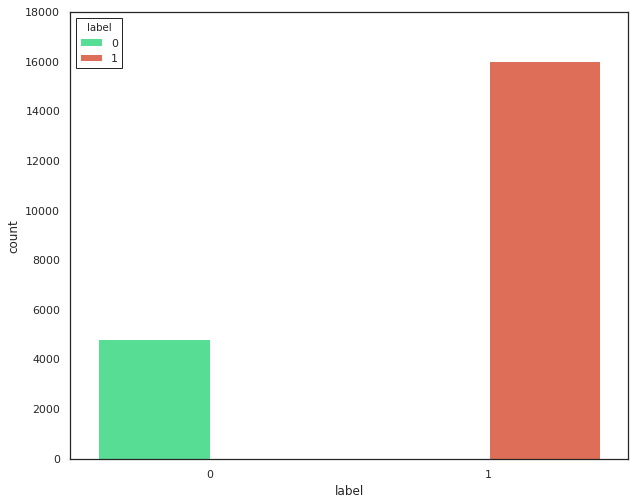

In [7]:
count_plot(initial_dataset, "label", (10,8))
print "Malicious URLs:\t{}".format(initial_dataset['label'][initial_dataset.label == 1].count())
print "Benign URLs:\t{}".format(initial_dataset['label'][initial_dataset.label == 0].count())

# Feature Engineering

In [8]:
# Method to count number of delimiters
def count_delimiters(url):
    count = 0
    delimiters = [';', '_', '?', '=', '&']
    for character in url:
        if character in delimiters:
            count += 1
    return count

In [9]:
def count_query_parameters(query):
    if not query:
        return 0
    else:
        return len(query.split('&'))

In [10]:
def compute_features(url):
    dbl_slash = url.count('//')
    extracted_tld = tlx.extract(url)
    parsed_url = urlparse(url)
    return dict({
        "hyphens": url.count('-'),
        "ats": url.count('@'),
        "dblbackslash": url.count('\\'),
        "fwdslash": url.count('/'),
        "dots": url.count('.'),
        "subdomaindots": extracted_tld.subdomain.count('.'),
        "urllength": len(url),
        "pathlength": len(parsed_url.path),
        "subdomainlength": len(extracted_tld.subdomain),
        "domainlength": len(extracted_tld.domain),
        "delimiters": count_delimiters(url),
        "parameters": count_query_parameters(parsed_url.query),
        "protocol": 1 if parsed_url.scheme == 'https' else 0,
        "dblfwdslash": dbl_slash if dbl_slash > 1 else 0,
        "ip": 1 if re.match(r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$",parsed_url.netloc) else 0
        
    })

In [11]:
def add_features(dataset, features):
    columns = features.copy()
    columns['url'] = []
    columns['label'] = []
    for i in range(len(dataset)):
        columns['url'].append(dataset['url'].iloc[i])
        columns['label'].append(dataset['label'].iloc[i])
        computed_features = compute_features(str(dataset['url'].iloc[i]))
        for column in columns.keys():
            if column not in ['url', 'label']:
                columns[column].append(computed_features[column])
    return columns

In [12]:
data = {
    "hyphens": [],
    "ats": [],
    "dblbackslash": [],
    "fwdslash": [],
    "dblfwdslash": [],
    "subdomainlength": [],
    "domainlength": [],
    "delimiters": [],
    "dots": [],
    "subdomaindots": [],
    "parameters": [],
    "protocol": [],
    "urllength": [],
    "pathlength": [],
    "ip": []
}
dtf = add_features(initial_dataset, data)
print_df_shape(initial_dataset)
dataset = pd.DataFrame(data=dtf)
dataset.head()

20875	rows
2	columns


,ats,dblbackslash,dblfwdslash,delimiters,domainlength,dots,fwdslash,hyphens,ip,label,parameters,pathlength,protocol,subdomaindots,subdomainlength,url,urllength
0,0,0,0,0,17,1,1,0,0,0,0,22,0,0,0,startbuyingstocks.com/,22
1,0,0,0,0,5,1,1,0,0,0,0,10,0,0,0,qqcvk.com/,10
2,0,0,0,0,13,1,1,0,0,0,0,18,0,0,0,432parkavenue.com/,18
3,0,0,0,0,11,1,1,0,0,0,0,15,0,0,0,gamefoliant.ru/,15
4,0,0,0,0,4,1,1,0,0,0,0,8,0,0,0,orka.cn/,8


# Data Analysis

### Distribution of URLs based on their length

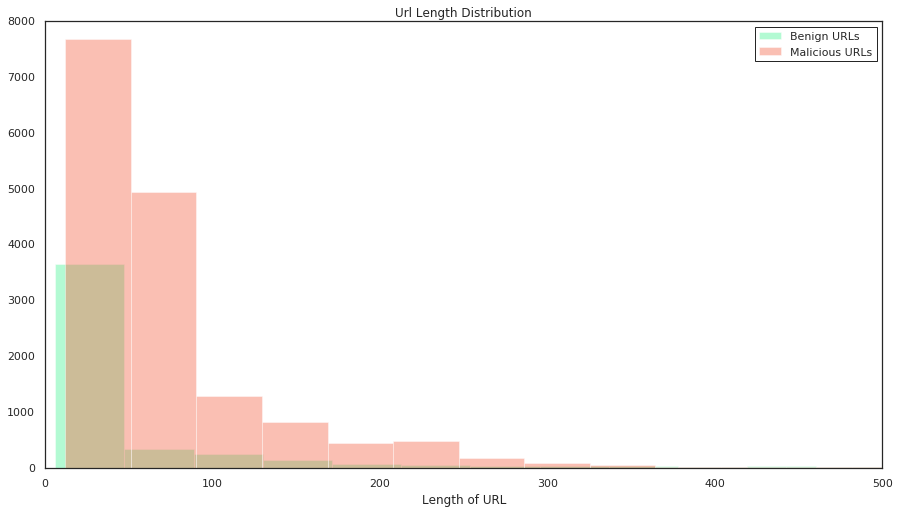

In [13]:
warnings.filterwarnings('ignore')
fig = plt.figure(figsize=(15,8))

sns.distplot(
    dataset[dataset['label']==0]['urllength'],
    color=green_color,
    label='Benign URLs',kde=False,
).set(xlim=(0, 500))
sns.distplot(
    dataset[dataset['label']==1]['urllength'],
    color=red_color,
    label='Malicious URLs',kde=False,
).set(xlim=(0, 500))
plt.title('Url Length Distribution')
plt.legend(loc='upper right')
plt.xlabel('Length of URL')

plt.show()

### Distribution of URLs based on number of parameters


Benign URLs description:
count    4847.000000
mean        1.934599
std         7.314726
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       115.000000
Name: parameters, dtype: float64

Malicious URLs description:
count    16028.000000
mean         0.598640
std          1.605177
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         23.000000
Name: parameters, dtype: float64


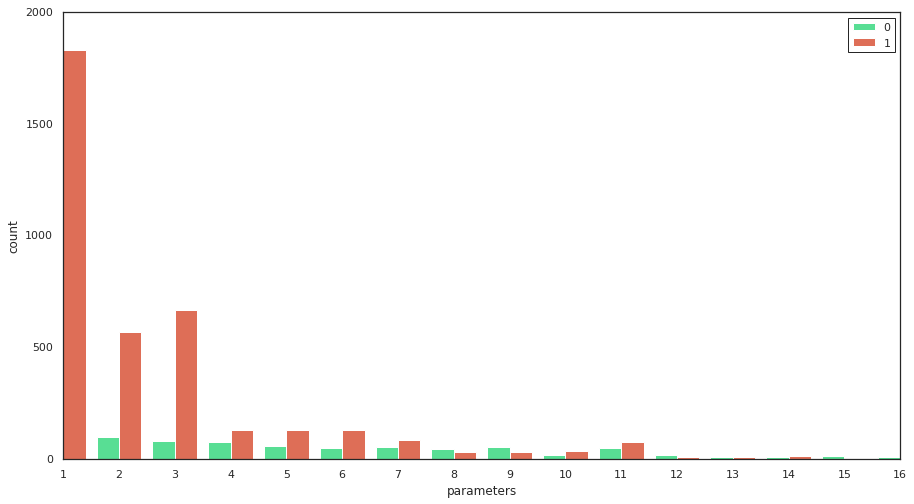

In [14]:
print "\nBenign URLs description:"
print dataset['parameters'][dataset.label == 0].describe()
print "\nMalicious URLs description:"
print dataset['parameters'][dataset.label == 1].describe()

count_plot(dataset[dataset["parameters"] > 0], "parameters",xlim=(0,15))

plt.legend(loc='upper right')

### Distribution of URLs based on number of dots in their domain


Benign URLs description:
count    4847.000000
mean        2.323086
std         3.309089
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        86.000000
Name: dots, dtype: float64

Malicious URLs description:
count    16028.000000
mean         2.396182
std          1.653489
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         29.000000
Name: dots, dtype: float64


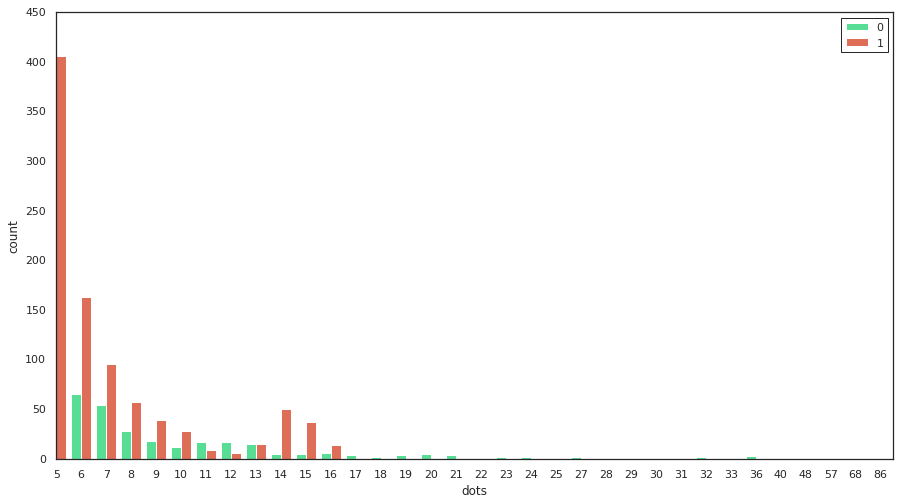

In [15]:
print "\nBenign URLs description:"
print dataset['dots'][dataset.label == 0].describe()
print "\nMalicious URLs description:"
print dataset['dots'][dataset.label == 1].describe()

count_plot(dataset[dataset['dots'] > 4], "dots",xlim=(0, None))

plt.legend(loc='upper right')

### Distribution of URLs based on number of dots in their subdomain


Benign URLs description:
count    4847.000000
mean        0.058180
std         0.292143
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         9.000000
Name: subdomaindots, dtype: float64

Malicious URLs description:
count    16028.000000
mean         0.065698
std          0.444304
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         12.000000
Name: subdomaindots, dtype: float64


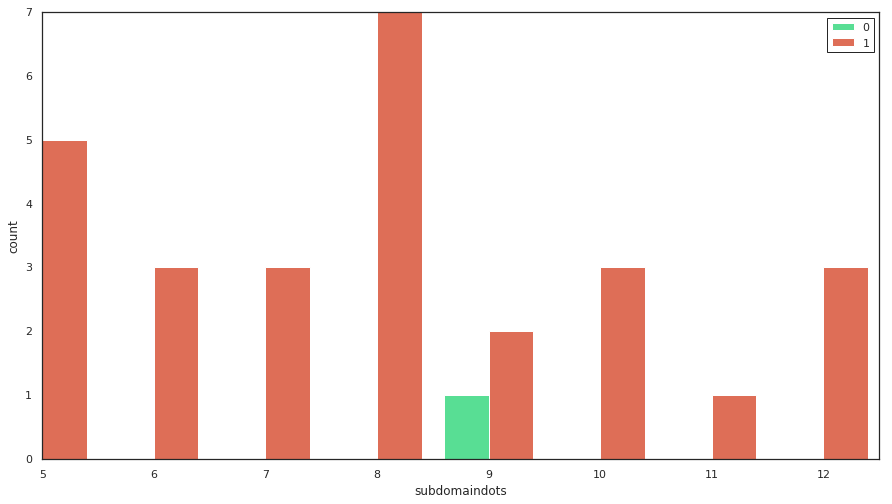

In [16]:
print "\nBenign URLs description:"
print dataset['subdomaindots'][dataset.label == 0].describe()
print "\nMalicious URLs description:"
print dataset['subdomaindots'][dataset.label == 1].describe()

count_plot(dataset[dataset['subdomaindots'] > 4], "subdomaindots",xlim=(0, None))

plt.legend(loc='upper right')


Benign URLs description:
count    4847.000000
mean        0.002888
std         0.064178
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: ats, dtype: float64

Malicious URLs description:
count    16028.000000
mean         0.056339
std          0.325889
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.000000
Name: ats, dtype: float64


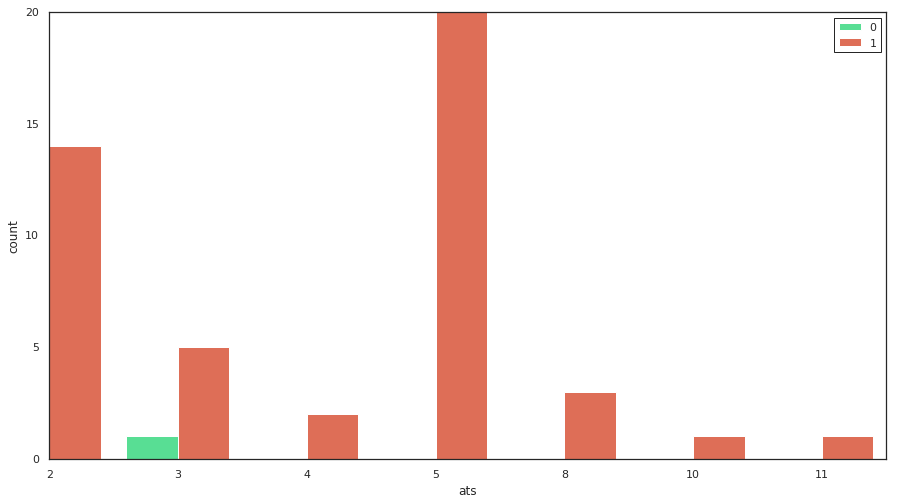

In [17]:
print "\nBenign URLs description:"
print dataset['ats'][dataset.label == 0].describe()
print "\nMalicious URLs description:"
print dataset['ats'][dataset.label == 1].describe()

count_plot(dataset[dataset['ats']>1], "ats",xlim=(0, None))

plt.legend(loc='upper right')

# Machine Learning Algorithms

In [18]:
import sklearn.ensemble as ek
from sklearn import model_selection, tree, linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [19]:
def fit_and_score(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

In [20]:
def cross_validate(model, X, y):
    return cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()

### Logistic Regression

In [21]:
X = dataset.drop(['url', 'label'], axis = 1).values
y = dataset['label'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

logreg = LogisticRegression()
start = time.time()
print "Logistic regression: {}".format(fit_and_score(logreg, X_train, y_train))
print "Cross validation result: {}".format(cross_validate(logreg, X, y))
print "Took {} s".format(time.time() - start)

Logistic regression: 0.969341317365
Cross validation result: 0.968815620438
Took 1.79374408722 s


### Decision Tree Classification

In [22]:
X = dataset.drop(['url', 'label'], axis = 1).values
y = dataset['label'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

dtc = tree.DecisionTreeClassifier(max_depth = 10)

start = time.time()
print "Decision Tree: {}".format(fit_and_score(dtc, X_train, y_train))
print "Cross validation result: {}".format(cross_validate(dtc, X, y))
print "Took {} s".format(time.time() - start)

Decision Tree: 0.985149700599
Cross validation result: 0.97719854458
Took 0.511215209961 s


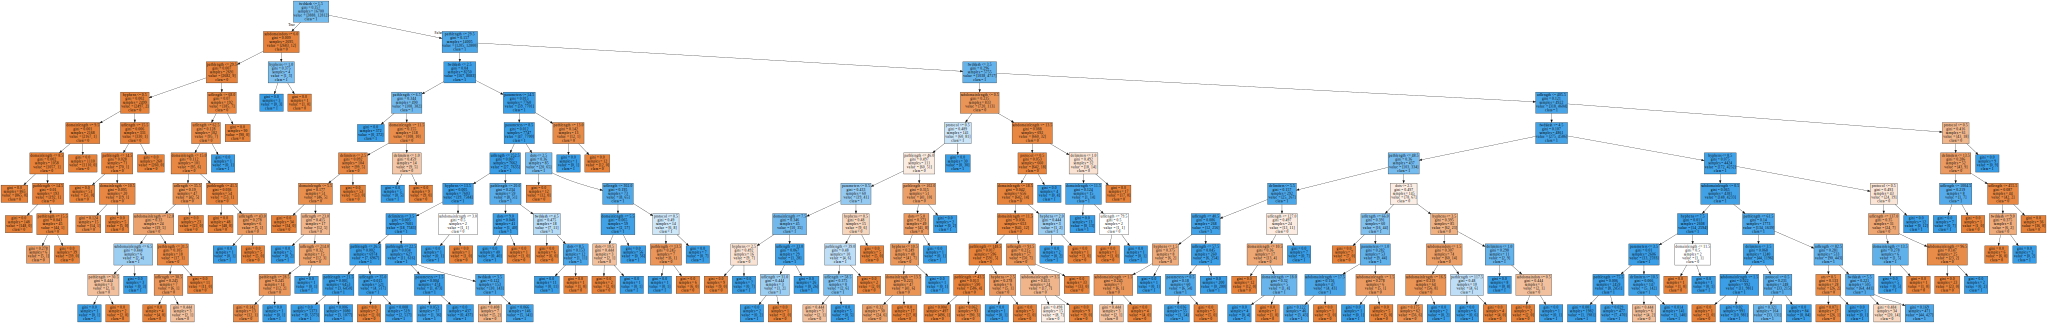

In [23]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.datasets import load_wine
from IPython.display import SVG
from graphviz import Source
from IPython.display import display



#estimator = DecisionTreeClassifier()
#estimator.fit(X, y)

graph = Source(tree.export_graphviz(dtc, out_file=None
   , feature_names=list(dataset.drop(['url', 'label'], axis = 1)), class_names=['0', '1', '2'] 
   , filled = True))
display(SVG(graph.pipe(format='svg')))

### Random Forest

In [24]:
X = dataset.drop(['url', 'label'], axis = 1).values
y = dataset['label'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

rf = ek.RandomForestClassifier(n_estimators = 200)

start = time.time()
print "Random Forest: {}".format(fit_and_score(rf, X_train, y_train))
print "Cross validation result: {}".format(cross_validate(rf, X, y))
print "Took {} s".format(time.time() - start)

Random Forest: 0.988023952096
Cross validation result: 0.988359900459
Took 17.5477609634 s


### KNeighbors

In [26]:
from sklearn.neighbors import KNeighborsClassifier

X = dataset.drop(['url', 'label'], axis = 1).values
y = dataset['label'].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2)

knn = KNeighborsClassifier(n_neighbors=3)

start = time.time()
print "KNN: {}".format(fit_and_score(knn, X_train, y_train))
print "Cross validation result: {}".format(cross_validate(knn, X, y))
print "Took {} s".format(time.time() - start)

KNN: 0.976526946108
Cross validation result: 0.970539781306
Took 1.32545399666 s
